In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
import torch.nn as nn
import time

In [2]:
# unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Define the display_top_predictions function
def display_top_predictions(dataloader, model, feature_extractor, device, top_k=5):
    model.eval()
    feature_extractor.eval()
    correct_pred = {classname: [] for classname in classes}
    incorrect_pred = {classname: [] for classname in classes}

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            for i in range(len(images)):
                label = labels[i]
                pred = preds[i]
                if pred == label:
                    correct_pred[classes[label.item()]].append(images[i])
                else:
                    incorrect_pred[classes[label.item()]].append(images[i])

    for classname, image_list in correct_pred.items():
        print(f'\nTop 5 correct predictions for class {classname}:')
        for i, image in enumerate(image_list[:top_k]):
            imshow(F.to_pil_image(torchvision.utils.make_grid(image)))
            print(f'Image {i+1}: Correctly predicted as {classname}')

    for classname, image_list in incorrect_pred.items():
        print(f'\nTop 5 incorrect predictions for class {classname}:')
        for i, image in enumerate(image_list[:top_k]):
            imshow(F.to_pil_image(torchvision.utils.make_grid(image)))
            print(f'Image {i+1}: Incorrectly predicted as {classname}')


In [3]:
# CIFAR-10 dataset loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Model definitions
resnet = resnet18(pretrained=True)
resnet.fc = nn.Identity()

class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(512, 10)  # 512 for ResNet18 output, 10 for CIFAR-10 classes

    def forward(self, x):
        return self.fc(x)

logistic_regression_model = LogisticRegression()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)
logistic_regression_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(logistic_regression_model.parameters(), lr=0.001)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Training function for logistic regression with timing
def train_logistic_regression_model(model, feature_extractor, train_loader, criterion, optimizer, num_epochs=5):
    model.to(device)
    feature_extractor.to(device)
    feature_extractor.eval()  
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time() 
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.no_grad():
                features = feature_extractor(inputs)
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if i % 200 == 199: 
                current_time = time.time()
                elapsed_time = current_time - epoch_start_time
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}, Time elapsed: {elapsed_time:.2f} sec')

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        estimated_total_time = epoch_duration * num_epochs
        remaining_time = estimated_total_time - (epoch_duration * (epoch + 1))
        print(f'Epoch {epoch + 1} finished in {epoch_duration:.2f} sec. Estimated time remaining: {remaining_time:.2f} sec.')


In [6]:
# Evaluation function
def evaluate_model(model, feature_extractor, test_loader):
    model.eval()
    feature_extractor.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            features = feature_extractor(inputs)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')

In [7]:
# Train and evaluate the logistic regression model
print("Training logistic regression model...")
train_logistic_regression_model(logistic_regression_model, resnet, trainloader, criterion, optimizer, num_epochs=5)
evaluate_model(logistic_regression_model, resnet, testloader)

Training logistic regression model...
Epoch 1, Batch 200, Loss: 1.3059691190719604, Time elapsed: 56.87 sec
Epoch 1, Batch 400, Loss: 1.2452808618545532, Time elapsed: 109.43 sec
Epoch 1, Batch 600, Loss: 1.2518970966339111, Time elapsed: 142.88 sec
Epoch 1 finished in 187.79 sec. Estimated time remaining: 751.16 sec.
Epoch 2, Batch 200, Loss: 1.33150053024292, Time elapsed: 52.48 sec
Epoch 2, Batch 400, Loss: 1.0617822408676147, Time elapsed: 75.59 sec
Epoch 2, Batch 600, Loss: 1.0602914094924927, Time elapsed: 97.16 sec
Epoch 2 finished in 140.28 sec. Estimated time remaining: 420.85 sec.
Epoch 3, Batch 200, Loss: 0.987433671951294, Time elapsed: 46.50 sec
Epoch 3, Batch 400, Loss: 0.9296770691871643, Time elapsed: 68.56 sec
Epoch 3, Batch 600, Loss: 1.1110581159591675, Time elapsed: 88.66 sec
Epoch 3 finished in 129.26 sec. Estimated time remaining: 258.51 sec.
Epoch 4, Batch 200, Loss: 1.1128708124160767, Time elapsed: 48.55 sec
Epoch 4, Batch 400, Loss: 1.033881664276123, Time ela

Epoch 1/100, Loss: 14638459904.0
Epoch 2/100, Loss: 8.041821185445532e+24
Epoch 3/100, Loss: inf
Epoch 4/100, Loss: inf
Epoch 5/100, Loss: nan
Epoch 6/100, Loss: nan
Epoch 7/100, Loss: nan
Epoch 8/100, Loss: nan
Epoch 9/100, Loss: nan
Epoch 10/100, Loss: nan
Epoch 11/100, Loss: nan
Epoch 12/100, Loss: nan
Epoch 13/100, Loss: nan
Epoch 14/100, Loss: nan
Epoch 15/100, Loss: nan
Epoch 16/100, Loss: nan
Epoch 17/100, Loss: nan
Epoch 18/100, Loss: nan
Epoch 19/100, Loss: nan
Epoch 20/100, Loss: nan
Epoch 21/100, Loss: nan
Epoch 22/100, Loss: nan
Epoch 23/100, Loss: nan
Epoch 24/100, Loss: nan
Epoch 25/100, Loss: nan
Epoch 26/100, Loss: nan
Epoch 27/100, Loss: nan
Epoch 28/100, Loss: nan
Epoch 29/100, Loss: nan
Epoch 30/100, Loss: nan
Epoch 31/100, Loss: nan
Epoch 32/100, Loss: nan
Epoch 33/100, Loss: nan
Epoch 34/100, Loss: nan
Epoch 35/100, Loss: nan
Epoch 36/100, Loss: nan
Epoch 37/100, Loss: nan
Epoch 38/100, Loss: nan
Epoch 39/100, Loss: nan
Epoch 40/100, Loss: nan
Epoch 41/100, Loss: n

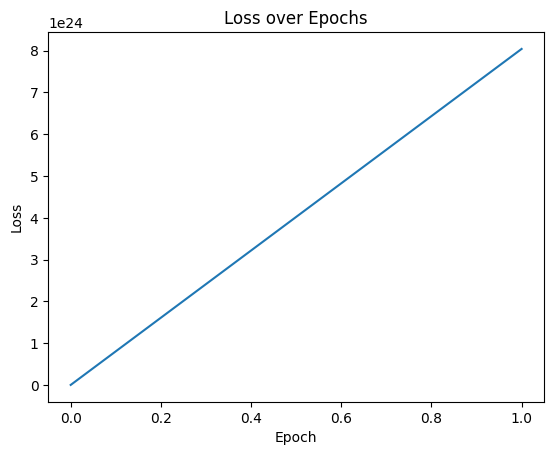

Movies recommended based on 'Apollo 13 (1995)':
BlacKkKlansman (2018)
Scary Movie 2 (2001)
Cats & Dogs (2001)
Lumumba (2000)
Crimson Rivers, The (Rivières pourpres, Les) (2000)
Closet, The (Placard, Le) (2001)
Princess and the Warrior, The (Krieger und die Kaiserin, Der) (2000)
Sexy Beast (2000)
Let It Snow (1999)
Pootie Tang (2001)


In [ ]:
import pandas as pd
import numpy as np
from torch.autograd import Variable
from torch.optim import SGD
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load the MovieLens dataset
ratings_path = '/Users/student/Desktop/SPRING 24/IDS 576/ml-latest-small/ratings.csv' 
movies_path = '/Users/student/Desktop/SPRING 24/IDS 576/ml-latest-small/movies.csv'   

ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

# Convert ratings to a binary preference
ratings['like'] = (ratings['rating'] >= 3.5).astype(int)

# Create a pivot table
pivot_table = ratings.pivot(index='userId', columns='movieId', values='like').fillna(0)

# Create a co-occurrence matrix
cooccurrence_matrix = pivot_table.T.dot(pivot_table)
np.fill_diagonal(cooccurrence_matrix.values, 0)

# Convert to torch tensors
X_ij = torch.tensor(cooccurrence_matrix.values, dtype=torch.float32)

# Number of movies
num_movies = X_ij.shape[0]

# Initialize embeddings
V = Variable(torch.rand(num_movies, 50), requires_grad=True)

# Define the optimization function
def cost_function(V, X_ij):
    VtV = torch.matmul(V, V.t())
    loss = (VtV - X_ij).pow(2).sum()
    return loss

# Optimization setup
optimizer = SGD([V], lr=0.01, momentum=0.9)

# Training loop
epochs = 100
loss_values = []

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = cost_function(V, X_ij)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Plot the loss over epochs
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()


def get_movie_recommendations(movie_title, movie_embeddings, movies_df, k=10):
    global movie_to_idx, idx_to_movie
    
    movie_id = movies_df.loc[movies_df['title'] == movie_title, 'movieId'].item()
    movie_idx = movie_to_idx.get(movie_id)
    if movie_idx is None:
        print(f"Movie title '{movie_title}' not found.")
        return []
    
    # Detach and reshape the query embedding tensor
    query_embedding = movie_embeddings[movie_idx].reshape(1, -1).detach().numpy()
    
    # Check for NaN values in the query embedding and handle them
    if np.isnan(query_embedding).any():
        query_embedding = np.nan_to_num(query_embedding)  # Replace NaN with 0
    
    # Detach the entire movie_embeddings tensor before using it
    embeddings_np = movie_embeddings.detach().numpy()
    
    # Check for NaN values in the embeddings and handle them
    if np.isnan(embeddings_np).any():
        embeddings_np = np.nan_to_num(embeddings_np)  # Replace NaN with 0
    
    # Calculate cosine similarity
    similarity = cosine_similarity(query_embedding, embeddings_np)
    
    top_k_indices = similarity[0].argsort()[-k:][::-1]
    recommendations = movies_df.iloc[top_k_indices]['title'].values
    return recommendations

# Create a mapping from movieId to index and vice versa
movie_to_idx = {movie: idx for idx, movie in enumerate(cooccurrence_matrix.columns)}
idx_to_movie = {idx: movie for movie, idx in movie_to_idx.items()}

# Get recommendations for a movie
recommended_movies = get_movie_recommendations('Apollo 13 (1995)', V, movies, k=10)
print("Movies recommended based on 'Apollo 13 (1995)':")
for movie in recommended_movies:
    print(movie)